## 神经网络用于计算机视觉

本章包括以下内容：

- 理解卷积神经网络（ConvNet）
- 使用数据增强（data argument）来降低过拟合
- 使用预训练的CNN进行特征提取
- 微调预训练的CNN
- 将CNN学到的内容及其如何做出分类决策可视化

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from IPython.display import Image

In [2]:
from keras import models, layers, optimizers, losses, metrics
from keras import Input
from keras.utils import plot_model

/home/pzhang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
model = models.Sequential()
model.add(
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

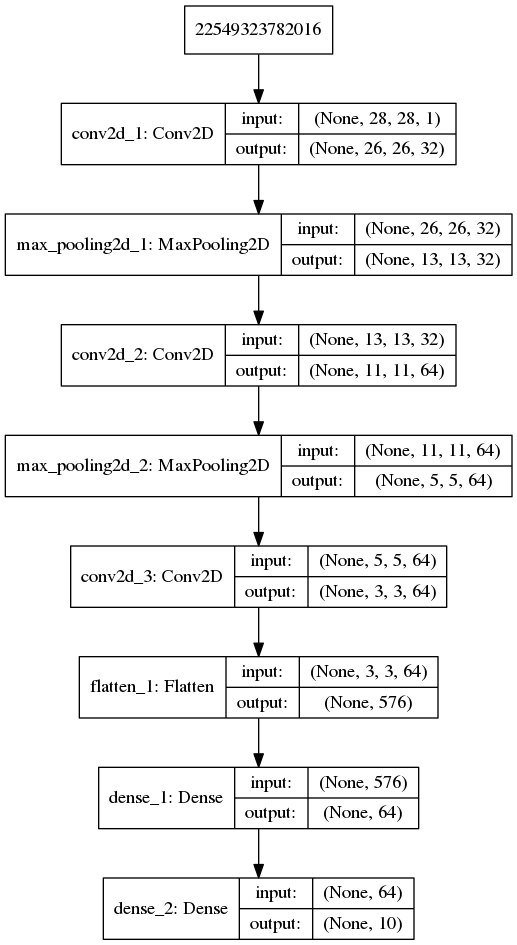

In [5]:
# plot model
# need pyplot, pyplot-ng and graphviz
plot_model(model, show_shapes=True, to_file='model.png')

Image(filename='model.png')

In [11]:
# 在MNIST上训练CNN
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

11493376/11490434 [==============================] - 256s 22us/step


In [12]:
model.compile(
    optimizer=optimizers.RMSprop(),
    loss=losses.categorical_crossentropy,
    metrics=[metrics.categorical_accuracy])

In [13]:
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
60000/60000 [==============================] - 9s 144us/step - loss: 0.1622 - categorical_accuracy: 0.9494
Epoch 2/5
60000/60000 [==============================] - 6s 92us/step - loss: 0.0453 - categorical_accuracy: 0.9857
Epoch 3/5
60000/60000 [==============================] - 6s 93us/step - loss: 0.0305 - categorical_accuracy: 0.9906
Epoch 4/5
60000/60000 [==============================] - 5s 86us/step - loss: 0.0241 - categorical_accuracy: 0.9926
Epoch 5/5
60000/60000 [==============================] - 5s 88us/step - loss: 0.0186 - categorical_accuracy: 0.9945


In [14]:
model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 60us/step


[0.026701377056132333, 0.9925]

In [15]:
model.save('mnist_cnn1.h5')

In [16]:
results = model.predict(test_images[:6], batch_size=1, verbose=1)
np.argmax(results, axis=1)

6/6 [==============================] - 0s 6ms/step


array([7, 2, 1, 0, 4, 1])

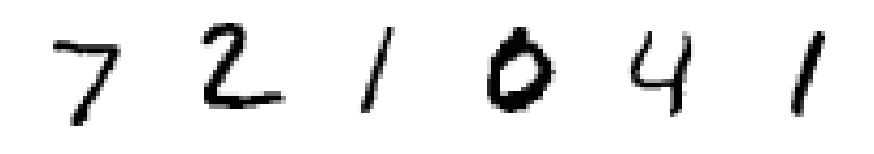

In [17]:
f, ax = plt.subplots(1, 6, figsize=(15,3))
for i, img in enumerate(test_images[:6]):
    ax[i].imshow(img.reshape(28, 28), cmap=plt.cm.binary)
    ax[i].axis('off')
plt.show()    

## 基于小数据集的CNN

Kaggle对猫和狗分类的数据集中包含4000张猫和够的图片。这里将其中2000张图片用于训练，1000张用于验证，1000张用于测试。

首先从该小数据集训练一个CNN

然后利用数据增强来降低过拟合

接着预训练的网络做特征提取以及对预训练的网络进行微调

In [6]:
!ls

cat_and_dog_1.h5   ch02.ipynb  create_small_cats_and_dogs_datasets.py
cat_and_dog_2.h5   ch03.ipynb  mnist_cnn1.h5
cat_and_dog.ipynb  ch05.ipynb  model.png


In [12]:
# split train, validation and test dataset
import os
import shutil

original_train_dir = '/home/pzhang/Downloads/ml_datasets/cat-and-dog/training_set'

base_dir = '/home/pzhang/Downloads/ml_datasets/cats_and_dogs_small'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

dir_list = ['train', 'validation', 'test']
ctag = ['cats', 'dogs']

for dir_name in dir_list:
    path = os.path.join(base_dir, dir_name)
    if not os.path.exists(path):
        os.mkdir(path)
    for n in ctag:
        temp_path = os.path.join(path, n)
        if not os.path.exists(temp_path):
            os.mkdir(temp_path)

# 将前1000张猫的图像复制到 cats_and_dogs_small/train/cats 目录
fnames = ['cat.{}.jpg'.format(i + 1) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_train_dir, 'cats', fname)
    dst = os.path.join(base_dir, 'train', 'cats', fname)
    shutil.copyfile(src, dst)
train_cats_dir, _ = os.path.split(dst)

# 接下来的500张猫的图像复制到 cats_and_dogs_small/vadiation/cats 目录
fnames = ['cat.{}.jpg'.format(i + 1) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_train_dir, 'cats', fname)
    dst = os.path.join(base_dir, 'validation', 'cats', fname)
    shutil.copyfile(src, dst)
validation_cats_dir, _ = os.path.split(dst)

# 接下来的500张猫的图像复制到 cats_and_dogs_small/test/cats 目录
fnames = ['cat.{}.jpg'.format(i + 1) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_train_dir, 'cats', fname)
    dst = os.path.join(base_dir, 'test', 'cats', fname)
    shutil.copyfile(src, dst)
test_cats_dir, _ = os.path.split(dst)

# 将前1000张狗的图像复制到 cats_and_dogs_small/train/dogs 目录
fnames = ['dog.{}.jpg'.format(i + 1) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_train_dir, 'dogs', fname)
    dst = os.path.join(base_dir, 'train', 'dogs', fname)
    shutil.copyfile(src, dst)
train_dogs_dir, _ = os.path.split(dst)

# 接下来的500张狗的图像复制到 cats_and_dogs_small/vadiation/dogs 目录
fnames = ['dog.{}.jpg'.format(i + 1) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_train_dir, 'dogs', fname)
    dst = os.path.join(base_dir, 'validation', 'dogs', fname)
    shutil.copyfile(src, dst)
validation_dogs_dir, _ = os.path.split(dst)

# 接下来的500张狗的图像复制到 cats_and_dogs_small/test/dogs 目录
fnames = ['dog.{}.jpg'.format(i + 1) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_train_dir, 'dogs', fname)
    dst = os.path.join(base_dir, 'test', 'dogs', fname)
    shutil.copyfile(src, dst)
    test_dogs_dir, _ = os.path.split(dst)

print('total training cat images: ', len(os.listdir(train_cats_dir)))
print('total training dog images: ', len(os.listdir(train_dogs_dir)))
print('total validation cat images: ', len(os.listdir(validation_cats_dir)))
print('total validation dog images: ', len(os.listdir(validation_dogs_dir)))
print('total test cat images: ', len(os.listdir(test_cats_dir)))
print('total test dog images: ', len(os.listdir(test_dogs_dir)))

total training cat images:  1000
total training dog images:  1000
total validation cat images:  500
total validation dog images:  500
total test cat images:  500
total test dog images:  500


### 构建网络

`Conv`和`MaxPooling`层交替堆叠

In [8]:
# use functional API
input_tensor = Input(shape=(150, 150, 3))

layer1 = layers.Conv2D(32, (3, 3), activation='relu')(input_tensor)
layer2 = layers.MaxPool2D((2, 2))(layer1)
layer3 = layers.Conv2D(64, 3, activation='relu')(layer2)
layer4 = layers.MaxPool2D(2)(layer3)
layer5 = layers.Conv2D(128, 3, activation='relu')(layer4)
layer6 = layers.MaxPool2D(2)(layer5)
layer7 = layers.Conv2D(128, 3, activation='relu')(layer6)
layer8 = layers.MaxPool2D(2)(layer7)
layer9 = layers.Flatten()(layer8)
layer10 = layers.Dense(512, activation='relu')(layer9)

output_tensor = layers.Dense(1, activation='sigmoid')(layer10)

model = models.Model(input_tensor, output_tensor)

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 17, 17, 128)       0         
__________

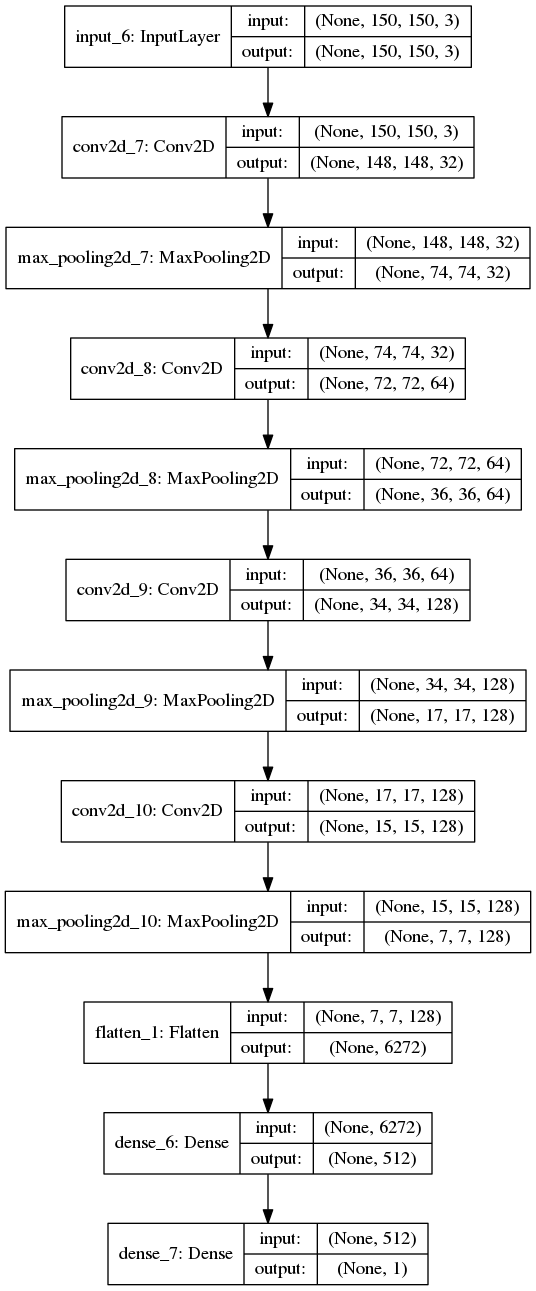

In [10]:
modelflow_filename = 'cats_and_dogs_small.png'
plot_model(model, show_shapes=True, to_file=modelflow_filename)

Image(filename=modelflow_filename)

In [11]:
# 编译模型
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-4),
    metrics=['accuracy'])

### 数据预处理

1. 读取图像文件
2. 将JPEG文件解码为RGB像素网格
3. 将这些像素网格转换为浮点数张量
4. 将像素值缩放至[0, 1]区间

In [25]:
from keras.preprocessing.image import ImageDataGenerator


train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

img_width = 150
img_height = 150
batch_size = 32

# -----------------------------------------------
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


查看以下其中一个生成器的输出

In [17]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 150, 150, 3)
labels batch shape: (32,)


现在使用批量拟合器来你和模型

In [18]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 12s 120ms/step - loss: 0.6819 - acc: 0.5556 - val_loss: 0.6579 - val_acc: 0.6066
Epoch 2/30
100/100 [==============================] - 8s 78ms/step - loss: 0.6338 - acc: 0.6310 - val_loss: 0.6229 - val_acc: 0.6591
Epoch 3/30
100/100 [==============================] - 8s 79ms/step - loss: 0.5647 - acc: 0.7113 - val_loss: 0.5854 - val_acc: 0.6808
Epoch 4/30
100/100 [==============================] - 8s 79ms/step - loss: 0.5279 - acc: 0.7366 - val_loss: 0.5950 - val_acc: 0.6701
Epoch 5/30
100/100 [==============================] - 8s 80ms/step - loss: 0.4967 - acc: 0.7553 - val_loss: 0.5518 - val_acc: 0.7176
Epoch 6/30
100/100 [==============================] - 8s 81ms/step - loss: 0.4629 - acc: 0.7766 - val_loss: 0.5686 - val_acc: 0.6952
Epoch 7/30
100/100 [==============================] - 8s 79ms/step - loss: 0.4363 - acc: 0.7913 - val_loss: 0.5474 - val_acc: 0.7278
Epoch 8/30
100/100 [==============================] - 8s 80ms/step 

In [40]:
model.save('cats_and_dogs_small_1.h5')

In [21]:
def plot_accuracy_and_loss(history):
    acc = history.history['acc']
    loss = history.history['loss']

    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']

    epochs = np.arange(len(acc)) + 1

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].plot(epochs, acc, 'bo', label='Training acc')
    ax[0].plot(epochs, val_acc, 'b', label='Validation acc')
    ax[0].legend(loc='best')

    ax[1].plot(epochs, loss, 'bo', label='Training loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation loss')
    ax[1].legend(loc='best')

    plt.show()

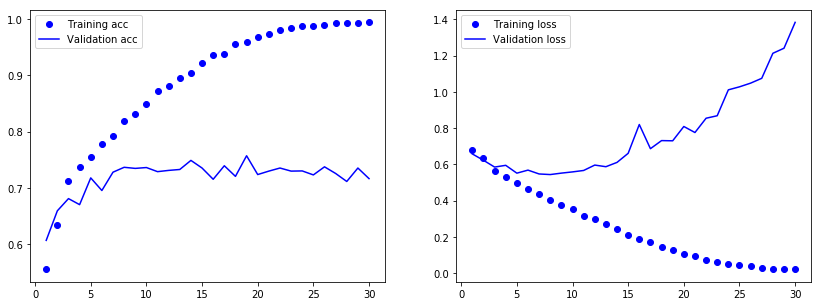

In [22]:
plot_accuracy_and_loss(history)

从图像中可以看出过拟合的特征。训练精度随着轮次一直在提高，而验证精度停留在70%~72%左右。

验证精度在5轮候达到最小。

### 使用数据增强


In [24]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

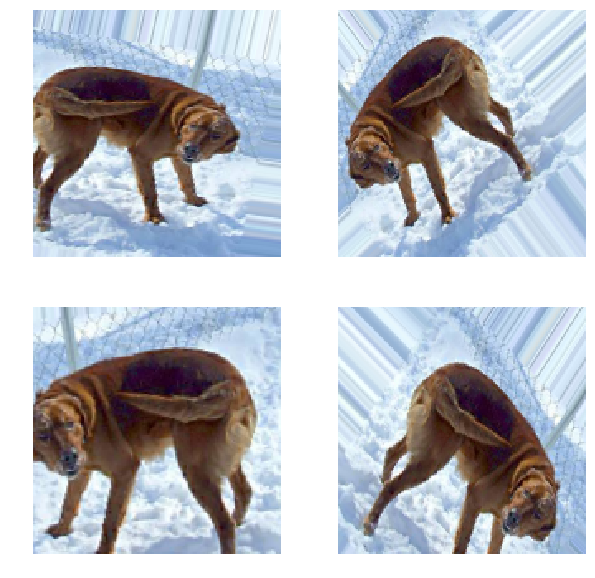

In [38]:
# display argumented image
from keras.preprocessing import image

fnames = [
    os.path.join(train_dogs_dir, fname) for fname in os.listdir(train_dogs_dir)
]

img_path = fnames[5]

img = image.load_img(img_path, target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

plt.figure(figsize=(10, 10))
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image.array_to_img(batch[0]))
    plt.axis('off')
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [39]:
# 定义一个包含Dropout的CNN
input_tensor = Input(shape=(150, 150, 3))

layer1 = layers.Conv2D(32, (3, 3), activation='relu')(input_tensor)
layer2 = layers.MaxPool2D((2, 2))(layer1)
layer3 = layers.Conv2D(64, 3, activation='relu')(layer2)
layer4 = layers.MaxPool2D(2)(layer3)
layer5 = layers.Conv2D(128, 3, activation='relu')(layer4)
layer6 = layers.MaxPool2D(2)(layer5)
layer7 = layers.Conv2D(128, 3, activation='relu')(layer6)
layer8 = layers.MaxPool2D(2)(layer7)
layer9 = layers.Flatten()(layer8)
layer10 = layers.Dropout(0.5)(layer9)
layer11 = layers.Dense(512, activation='relu')(layer10)

output_tensor = layers.Dense(1, activation='sigmoid')(layer11)

model = models.Model(input_tensor, output_tensor)

In [41]:
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-4),
    metrics=['acc'])